# Base de dados e importações

In [ ]:
!gdown --id 1XBuAcUSvrOuiDgPavoUFbwn_dLn7OwYs --output dados.zip
!unzip dados.zip
!gdown --id 1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_ --output CSV.zip
!unzip CSV.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: content/audios_MFCC_especialistas_plus_adicional_8750/aa716ab2-0bdb-4e5c-ad2d-4c59c9566e06.jpg  
  inflating: content/audios_MFCC_especialistas_plus_adicional_8750/b09a9f07-62d0-44fa-b3da-b4716361eb88.jpg  
  inflating: content/audios_MFCC_especialistas_plus_adicional_8750/50bde838-dacb-4d59-9d62-d15bb45712bb.jpg  
  inflating: content/audios_MFCC_especialistas_plus_adicional_8750/b6c07ded-853d-41e0-a5d4-a2b9ef5ef849.jpg  
  inflating: content/audios_MFCC_especialistas_plus_adicional_8750/9d3acba2-e1a3-4af8-9147-53e1ad5011c4.jpg  
  inflating: content/audios_MFCC_especialistas_plus_adicional_8750/b1df4b23-b23c-42c1-9aef-795ea5aa6991.jpg  
  inflating: content/audios_MFCC_especialistas_plus_adicional_8750/25caa3a5-db4c-46b7-b5fe-4d673609db61.jpg  
  inflating: content/audios_MFCC_especialistas_plus_adicional_8750/2fb4f3a5-bc1d-4ad0-8e58-dba4e3b40e2f.jpg  
  inflating: content/audios_MFCC_especialistas_plus_adicional

In [ ]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv('/content/CSV/train.csv')
val = pd.read_csv('/content/CSV/val.csv')
train_aug = pd.read_csv('/content/CSV/train_additional_data.csv')
train = pd.concat([train, train_aug])
train

,original_index,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,cough_type_3,diagnosis_3,severity_3
0,12581,a084b953-189d-422d-a40a-b545b4f01618,2020-04-03T09:30:06.071538+00:00,0.8629,NaN,NaN,27.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,False,False,False,True,dry,lower_infection,mild
1,8700,6dff10f3-5df0-4b5a-be62-613afd6115dc,2020-04-24T19:00:52.634932+00:00,0.9948,41.7,2.8,57.0,male,False,False,healthy,ok,dry,False,False,False,False,False,True,healthy_cough,pseudocough,good,dry,False,True,False,False,False,False,obstructive_disease,mild,good,False,False,False,False,False,True,wet,lower_infection,mild
2,555,075cdb5a-5c29-4266-84ea-c44963bd0454,2020-04-11T16:58:29.950572+00:00,0.9961,NaN,NaN,29.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ok,dry,False,False,False,False,True,False,upper_infection,pseudocough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18845,f0da0dd1-a4d1-47ac-bc31-e9c6ceb05e28,2020-05-12T09:56:47.381630+00:00,0.9624,NaN,NaN,44.0,male,False,False,healthy,ok,wet,False,False,False,False,False,True,lower_infection,mild,ok,wet,False,False,False,True,False,False,lower_infection,mild,good,False,False,False,False,False,True,wet,lower_infection,mild
4,7553,5fe2cece-1061-4f53-b4ac-64a07efc6ba1,2020-04-11T20:33:24.800041+00:00,953.0000,40.4,-3.7,49.0,male,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ok,dry,False,False,False,False,False,True,upper_infection,mild,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,20064,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,2020-04-22T05:40:51.730942+00:00,0.5591,13.0,77.6,26.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7010,20065,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,2020-06-05T03:41:37.481463+00:00,0.9498,-34.5,-58.5,23.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7011,20066,ffeea120-92a4-40f9-b692-c3865c7a983f,2020-05-02T10:18:27.348859+00:00,0.9784,14.3,121.1,22.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7012,20067,fff13fa2-a725-49ef-812a-39c6cedda33d,2020-04-13T17:51:36.956822+00:00,0.7154,31.9,34.7,21.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Foi efetuado o mapeamento das classes que até então era string categórico, para os valores 0, 1 e 2.

*   healthy - 0 
*   symptomatic -  1 
*   COVID-19 - 2










In [ ]:
train['classInt'] = train['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
val['classInt'] = val['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
train['classStr'] = train['classInt'].astype('str')
val['classStr'] = val['classInt'].astype('str')
train['uuid'] = train['uuid'] + '.jpg'
val['uuid'] = val['uuid'] + '.jpg'

Utilizou-se os pesos para cada classe como forma de lidar com o desbalanceamento dos dados.

Ficando dessa forma:

*   healthy -  representado pelo 0 - ficou com o peso 1.0
*   symptomatic -  represenatado pelo 1 - ficou com o peso 5.826048171275647 
*   COVID-19 - represenatado pelo 2 - ficou com o peso 13.807610993657505

In [ ]:
# Determinando os pesos
counter = Counter(train['classInt'])  
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weights 

{0: 1.0, 1: 5.826048171275647, 2: 13.807610993657505}

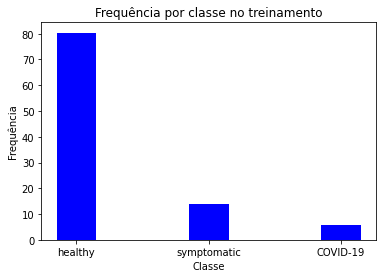

In [ ]:
plt.bar(0, len(train.values[train.classInt.values == 0])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(1, len(train.values[train.classInt.values == 1])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(2, len(train.values[train.classInt.values == 2])/len(train.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no treinamento')
plt.savefig('Treinamento-aumentacao.png')

# Função para treinamento de modelos


Como foi analisado que a execução de uma época da rede dura poucos segundos iremos testar a base com esse pré-processamento em 21 redes diferentes da imagenet para ver qual obteve a melhor acurácia tornando-a por fim o nosso baseline inicial. As redes a serem analisadas são listadas abaixo:

ResNet50
ResNet101	
ResNet152	
EfficientNetB0
EfficientNetB1
EfficientNetB2
EfficientNetB3
EfficientNetB4
EfficientNetB5	
EfficientNetB6	
EfficientNetB7	
MobileNet	
MobileNetV2	
DenseNet121	
DenseNet169	
DenseNet201	
InceptionV3	
InceptionResNetV2	
Xception	
VGG16	
VGG19	

A seguir temos uma função genérica onde suporta a chamada de várias redes da imagenet, para facilitar a criação dos modelos junto com o conjunto de parâmetros relacionados a cada uma delas.

In [ ]:
def cria_e_treina_rede(model_name, train_df, val_df, batch_size=32, callbacks=[], image_size=(256, 256), pooling='avg', loss='categorical_crossentropy', epochs=500, class_weights=class_weights, trainable=True):

  if model_name == 'resnet50' or model_name == 'resnet101' or model_name == 'resnet152':
    preprocessing_function = tf.keras.applications.resnet.preprocess_input
  elif model_name == 'efficientnetb0' or model_name == 'efficientnetb1' or model_name == 'efficientnetb2' or model_name == 'efficientnetb3' or model_name == 'efficientnetb4' or model_name == 'efficientnetb5'  or model_name == 'efficientnetb6' or model_name == 'efficientnetb7':
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
  elif model_name == 'mobilenet':
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input
  elif model_name == 'mobilenetv2':
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
  elif model_name == 'densenet121' or model_name == 'densenet169' or model_name == 'densenet201':
    preprocessing_function = tf.keras.applications.densenet.preprocess_input
  elif model_name == 'inceptionv3':
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
  elif model_name == 'inceptionresnetv2':
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input
  elif model_name == 'xception':
    preprocessing_function = tf.keras.applications.xception.preprocess_input
  elif model_name == 'vgg16':
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
  elif model_name == 'vgg19':
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input

  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocessing_function,
  )

  train_generator = datagen.flow_from_dataframe(
    train_df, directory='/content/content/audios_MFCC_especialistas_plus_adicional_8750', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42, color_mode='rgb')

  val_generator = datagen.flow_from_dataframe(
    val_df, directory='/content/content/audios_MFCC_especialistas_plus_adicional_8750', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=False, seed=42, color_mode='rgb')
  
  if model_name == 'resnet50':
    pre_trained = tf.keras.applications.ResNet50(include_top=False, pooling=pooling)
  elif model_name == 'resnet101':
    pre_trained = tf.keras.applications.ResNet101(include_top=False, pooling=pooling)
  elif model_name == 'resnet152':
    pre_trained = tf.keras.applications.ResNet152(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb0':
    pre_trained = tf.keras.applications.EfficientNetB0(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb1':
    pre_trained = tf.keras.applications.EfficientNetB1(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb2':
    pre_trained = tf.keras.applications.EfficientNetB2(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb3':
    pre_trained = tf.keras.applications.EfficientNetB3(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb4':
    pre_trained = tf.keras.applications.EfficientNetB4(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb5':
    pre_trained = tf.keras.applications.EfficientNetB5(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb6':
    pre_trained = tf.keras.applications.EfficientNetB6(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb7':
    pre_trained = tf.keras.applications.EfficientNetB7(include_top=False, pooling=pooling)
  elif model_name == 'mobilenet':
    pre_trained = tf.keras.applications.MobileNet(include_top=False, pooling=pooling)
  elif model_name == 'mobilenetv2':
    pre_trained = tf.keras.applications.MobileNetV2(include_top=False, pooling=pooling)
  elif model_name == 'densenet121':
    pre_trained = tf.keras.applications.DenseNet121(include_top=False, pooling=pooling)
  elif model_name == 'densenet169':
    pre_trained = tf.keras.applications.DenseNet169(include_top=False, pooling=pooling)
  elif model_name == 'densenet201':
    pre_trained = tf.keras.applications.DenseNet201(include_top=False, pooling=pooling)
  elif model_name == 'inceptionv3':
    pre_trained = tf.keras.applications.InceptionV3(include_top=False, pooling=pooling)
  elif model_name == 'inceptionresnetv2':
    pre_trained = tf.keras.applications.InceptionResNetV2(include_top=False, pooling=pooling)
  elif model_name == 'xception':
    pre_trained = tf.keras.applications.Xception(include_top=False, pooling=pooling)
  elif model_name == 'vgg16':
    pre_trained = tf.keras.applications.VGG16(include_top=False, pooling=pooling)
  elif model_name == 'vgg19':
    pre_trained = tf.keras.applications.VGG19(include_top=False, pooling=pooling)

  for layer in pre_trained.layers:
    layer.treinable = trainable

  model = tf.keras.models.Sequential([
   pre_trained,
   tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.summary()

  optimizer = tf.keras.optimizers.Adam(0.000001)

  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  list_of_callbacks = []
  if 'earlystopping' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True, verbose=1))
  if 'reducelr' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, mode="min", verbose=1))
  if 'checkpoint' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('/content/' + model_name + '.hdf5', save_best_only=True, verbose=1))

  history = model.fit(train_generator, validation_data=val_generator, batch_size=batch_size, class_weight=class_weights, callbacks=list_of_callbacks, epochs=epochs)

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title(model_name + ' accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name + ' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  predict_val = model.predict(val_generator, verbose=1)
  y_true = []

  i = 0
  for batch, label in val_generator:
    i += batch.shape[0]
    for l in np.argmax(label, axis=1):
      y_true.append(l)
    if i == len(val_df): break

  y_true = np.array(y_true)

  print(confusion_matrix(y_true, np.argmax(predict_val, axis=1)))

  cm = confusion_matrix(y_true, np.argmax(predict_val, axis=1))
  cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cm) / 3
  print('Acuracia balanceada na validacao:', balanced_acc)

  return model

# Modelos

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
254/254 [==============================] - 59s 147ms/step - loss: 3.3805 - acc: 0.0747 - val_loss: 1.3507 - val_acc: 0.3129
Epoch 2/500
254/254 [====================

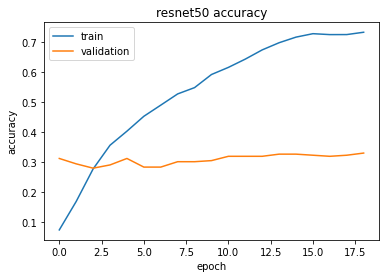

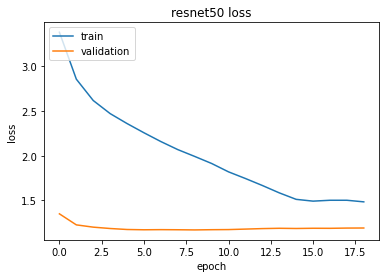

9/9 [==============================] - 2s 77ms/step
[[34 31 23]
 [59 29 19]
 [40 22 21]]
Acuracia balanceada na validacao: 0.303467907313195


In [ ]:
cria_e_treina_rede('resnet50', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
171450368/171446536 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 42,664,323
Trainable params: 42,558,979
Non-trainable params: 105,344
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 70s 237ms/step - loss: 2.8933 - acc: 0.4404 - val_loss: 1.1775 - val_acc: 0.3453
Epoch 2/500
254/254 [==============================] - 58s 229ms/step - loss: 2.6655 - acc: 0.4167 - val_loss: 1.1179 - val_acc: 0.3813
Epoch 3/500
254/254 [=================

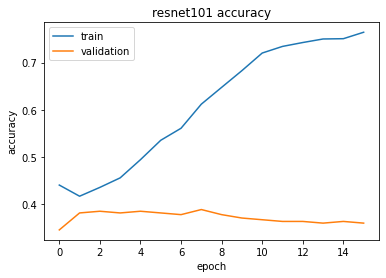

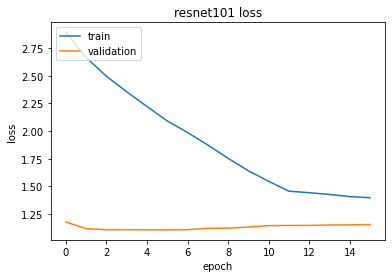

9/9 [==============================] - 2s 80ms/step
[[47 26 15]
 [50 33 24]
 [36 21 26]]
Acuracia balanceada na validacao: 0.385251712030791


In [ ]:
cria_e_treina_rede('resnet101', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
234700800/234698864 [==============================] - 8s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2048)              58370944  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 58,377,091
Trainable params: 58,225,667
Non-trainable params: 151,424
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 101s 336ms/step - loss: 2.9781 - acc: 0.1920 - val_loss: 1.2193 - val_acc: 0.3957
Epoch 2/500
254/254 [==============================] - 83s 325ms/step - loss: 2.6520 - acc: 0.2768 - val_loss: 1.1564 - val_acc: 0.3633
Epoch 3/500
254/254 [================

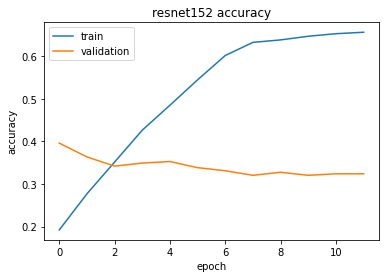

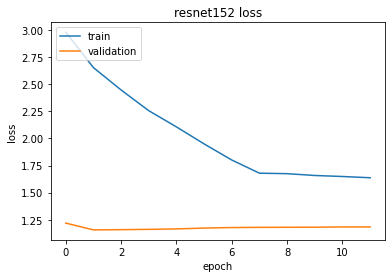

9/9 [==============================] - 3s 98ms/step
[[28 40 20]
 [25 49 33]
 [23 36 24]]
Acuracia balanceada na validacao: 0.35509412330716233


In [ ]:
cria_e_treina_rede('resnet152', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 4,011,391
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 59s 199ms/step - loss: 2.8072 - acc: 0.4032 - val_loss: 1.1251 - val_acc: 0.3705
Epoch 2/500
254/254 [==============================] - 49s 191ms/step - loss: 2.7835 - acc: 0.4070 - val_loss: 1.1210 - val_acc: 0.3489
Epoch 3/500
254/254 [======================

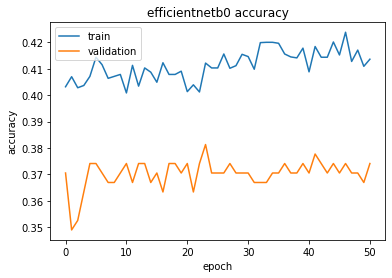

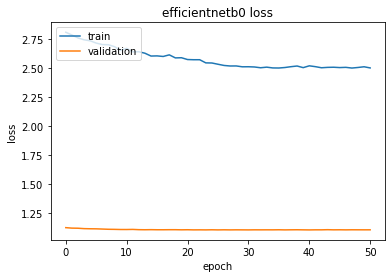

9/9 [==============================] - 2s 56ms/step
[[38 32 18]
 [43 39 25]
 [29 28 26]]
Acuracia balanceada na validacao: 0.3698523917249286


In [ ]:
cria_e_treina_rede('efficientnetb0', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
27025408/27018416 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3843      
Total params: 6,579,082
Trainable params: 6,517,027
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 85s 291ms/step - loss: 2.7745 - acc: 0.3868 - val_loss: 1.1081 - val_acc: 0.3741
Epoch 2/500
254/254 [==============================] - 72s 282ms/step - loss: 2.7519 - acc: 0.3845 - val_loss: 1.1427 - val_acc: 0.3058
Epoch 3/500
254/254 [======================

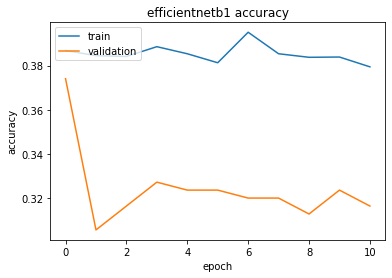

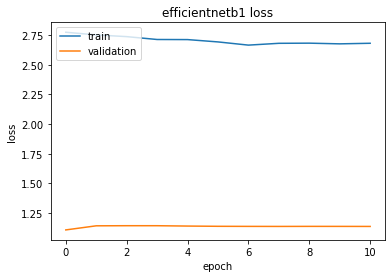

9/9 [==============================] - 2s 60ms/step
[[30 41 17]
 [27 60 20]
 [33 36 14]]
Acuracia balanceada na validacao: 0.35677715108522445


In [ ]:
cria_e_treina_rede('efficientnetb1', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
31793152/31790344 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 4227      
Total params: 7,772,796
Trainable params: 7,705,221
Non-trainable params: 67,575
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 88s 304ms/step - loss: 2.7228 - acc: 0.4273 - val_loss: 1.1044 - val_acc: 0.3525
Epoch 2/500
254/254 [==============================] - 75s 293ms/step - loss: 2.7126 - acc: 0.4213 - val_loss: 1.1112 - val_acc: 0.3993
Epoch 3/500
254/254 [======================

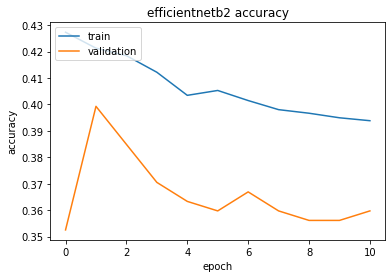

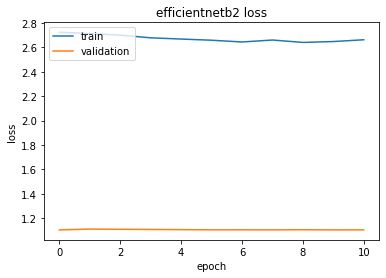

9/9 [==============================] - 2s 57ms/step
[[34 39 15]
 [43 53 11]
 [32 40 11]]
Acuracia balanceada na validacao: 0.33807361988310086


In [ ]:
cria_e_treina_rede('efficientnetb2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
43941888/43941136 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 4611      
Total params: 10,788,146
Trainable params: 10,700,843
Non-trainable params: 87,303
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 105s 361ms/step - loss: 2.7504 - acc: 0.3130 - val_loss: 1.1077 - val_acc: 0.3957
Epoch 2/500
254/254 [==============================] - 89s 349ms/step - loss: 2.7706 - acc: 0.3135 - val_loss: 1.1334 - val_acc: 0.2914
Epoch 3/500
254/254 [===================

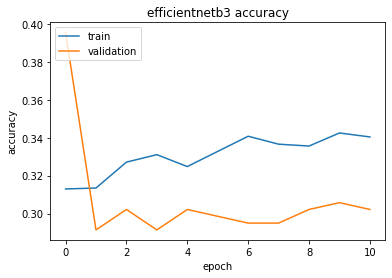

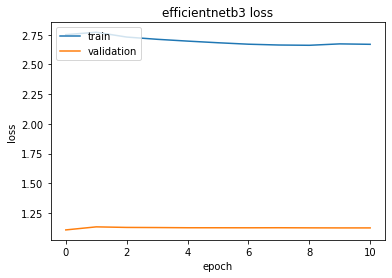

9/9 [==============================] - 2s 59ms/step
[[14 62 12]
 [16 74 17]
 [11 50 22]]
Acuracia balanceada na validacao: 0.3719133117004978


In [ ]:
cria_e_treina_rede('efficientnetb3', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
71688192/71686520 [==============================] - 2s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 5379      
Total params: 17,679,202
Trainable params: 17,553,995
Non-trainable params: 125,207
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 127s 437ms/step - loss: 2.7080 - acc: 0.3745 - val_loss: 1.1251 - val_acc: 0.3273
Epoch 2/500
254/254 [==============================] - 108s 424ms/step - loss: 2.6982 - acc: 0.3760 - val_loss: 1.1416 - val_acc: 0.3273
Epoch 3/500
254/254 [=================

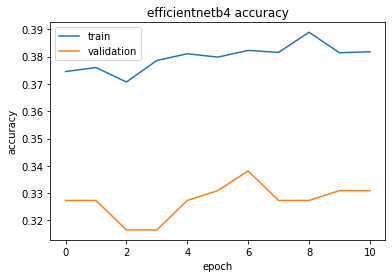

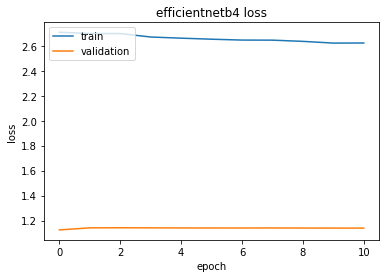

9/9 [==============================] - 3s 61ms/step
[[43 23 22]
 [50 30 27]
 [45 20 18]]
Acuracia balanceada na validacao: 0.32862588843052754


In [ ]:
cria_e_treina_rede('efficientnetb4', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
115269632/115263384 [==============================] - 2s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 6147      
Total params: 28,519,674
Trainable params: 28,346,931
Non-trainable params: 172,743
_________________________________________________________________
Epoch 1/500
508/508 [==============================] - 190s 333ms/step - loss: 2.7118 - acc: 0.3126 - val_loss: 1.1357 - val_acc: 0.3273
Epoch 2/500
508/508 [==============================] - 165s 325ms/step - loss: 2.6889 - acc: 0.3159 - val_loss: 1.1345 - val_acc: 0.3309
Epoch 3/500
508/508 [===============

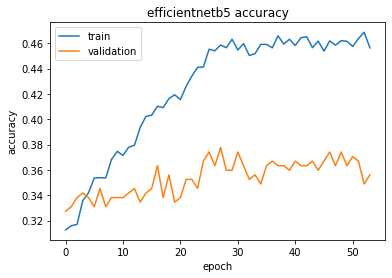

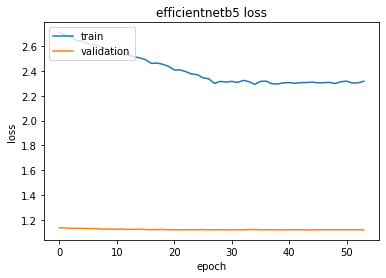

18/18 [==============================] - 4s 47ms/step
[[37 25 26]
 [32 37 38]
 [30 25 28]]
Acuracia balanceada na validacao: 0.3678661118560904


In [ ]:
cria_e_treina_rede('efficientnetb5', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
165240832/165234480 [==============================] - 2s 0us/step
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 2304)              40960143  
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 6915      
Total params: 40,967,058
Trainable params: 40,742,619
Non-trainable params: 224,439
_________________________________________________________________
Epoch 1/500
508/508 [==============================] - 229s 405ms/step - loss: 2.7117 - acc: 0.3546 - val_loss: 1.1079 - val_acc: 0.3309
Epoch 2/500
508/508 [==============================] - 201s 396ms/step - loss: 2.6911 - acc: 0.3531 - val_loss: 1.1055 - val_acc: 0.3453
Epoch 3/500
508/508 [===============

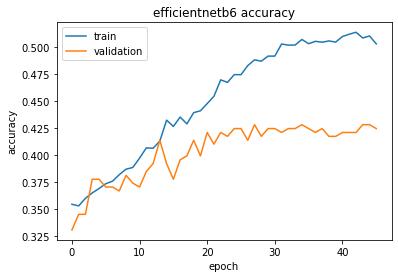

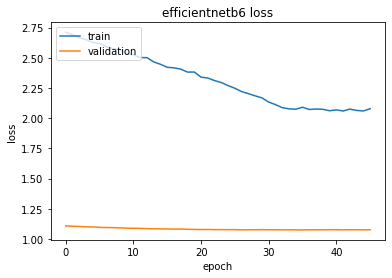

18/18 [==============================] - 4s 61ms/step
[[35 33 20]
 [25 53 29]
 [26 27 30]]
Acuracia balanceada na validacao: 0.41816671955451373


In [ ]:
cria_e_treina_rede('efficientnetb6', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
258080768/258076736 [==============================] - 4s 0us/step
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 2560)              64097687  
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 7683      
Total params: 64,105,370
Trainable params: 63,794,643
Non-trainable params: 310,727
_________________________________________________________________
Epoch 1/500
1016/1016 [==============================] - 336s 305ms/step - loss: 2.6831 - acc: 0.3722 - val_loss: 1.1247 - val_acc: 0.3309
Epoch 2/500
1016/1016 [==============================] - 304s 299ms/step - loss: 2.6638 - acc: 0.3735 - val_loss: 1.1210 - val_acc: 0.3489
Epoch 3/500
1016/1016 [========

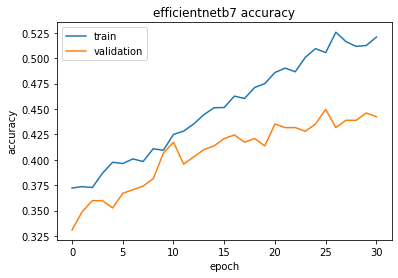

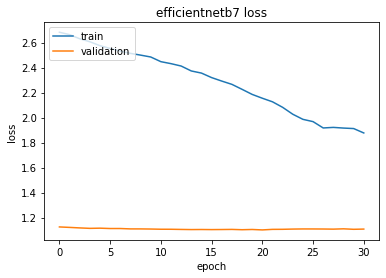

35/35 [==============================] - 7s 48ms/step
[[34 28 26]
 [32 48 27]
 [18 26 39]]
Acuracia balanceada na validacao: 0.434947095092349


In [ ]:
cria_e_treina_rede('efficientnetb7', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=8)

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 40s 146ms/step - loss: 3.3717 - acc: 0.3409 - val_loss: 1.3190 - val_acc: 0.3669
Epoch 2/500
254/254 [==============================] - 37s 144ms/step - loss: 3.2016 - acc: 0.3444 - val_loss: 1.3002 - val_acc: 0.3453
Epoch 3/500
254/254 [=====================

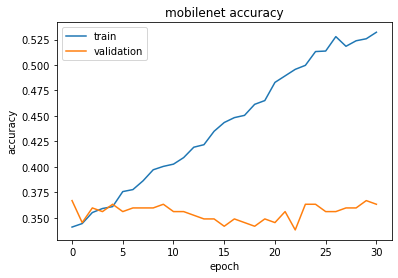

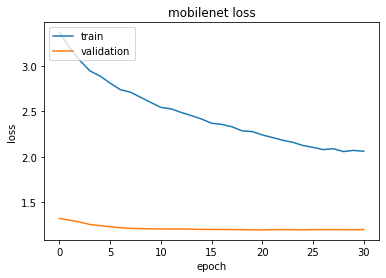

9/9 [==============================] - 1s 61ms/step
[[36 33 19]
 [36 38 33]
 [34 27 22]]
Acuracia balanceada na validacao: 0.34309711232355083


In [ ]:
cria_e_treina_rede('mobilenet', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 44s 156ms/step - loss: 3.2210 - acc: 0.4263 - val_loss: 1.3301 - val_acc: 0.3777
Epoch 2/500
254/254 [==============================] - 39s 153ms/step - loss: 3.0748 - acc: 0.4325 - val_loss: 1.2968 - val_acc: 0.3561
Epoch 3/500
254/254 [=======================

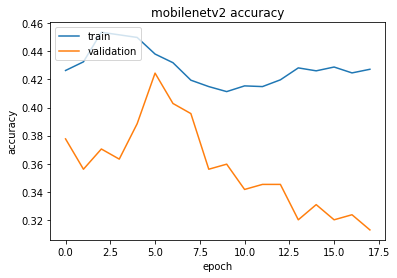

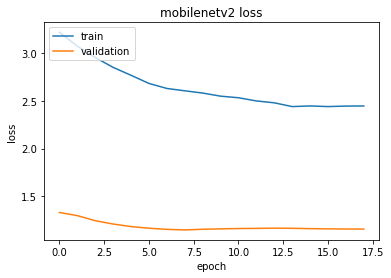

9/9 [==============================] - 1s 61ms/step
[[46 28 14]
 [40 41 26]
 [31 29 23]]
Acuracia balanceada na validacao: 0.3943377588518901


In [ ]:
cria_e_treina_rede('mobilenetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 6,956,931
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 54s 168ms/step - loss: 4.1713 - acc: 0.1598 - val_loss: 1.5610 - val_acc: 0.3777
Epoch 2/500
254/254 [==============================] - 39s 152ms/step - loss: 3.8542 - acc: 0.1678 - val_loss: 1.5057 - val_acc: 0.3741
Epoch 3/500
254/254 [=====================

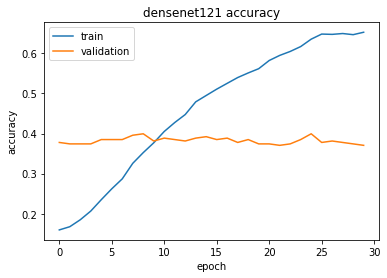

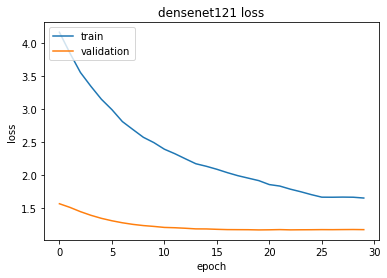

9/9 [==============================] - 2s 71ms/step
[[33 39 16]
 [41 54 12]
 [33 33 17]]
Acuracia balanceada na validacao: 0.36149739143489845


In [ ]:
cria_e_treina_rede('densenet121', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
51879936/51877672 [==============================] - 1s 0us/step
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 4995      
Total params: 12,647,875
Trainable params: 12,489,475
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 65s 202ms/step - loss: 2.9137 - acc: 0.5450 - val_loss: 1.2284 - val_acc: 0.3022
Epoch 2/500
254/254 [==============================] - 48s 188ms/step - loss: 2.7386 - acc: 0.5215 - val_loss: 1.1970 - val_acc: 0.3237
Epoch 3/500
254/254 [==================

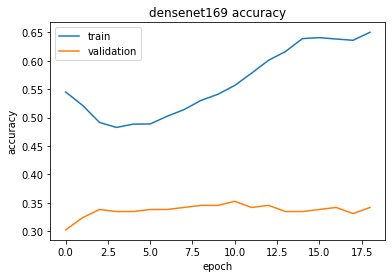

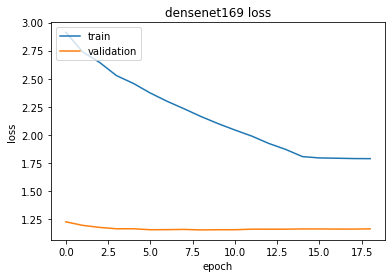

9/9 [==============================] - 3s 75ms/step
[[39 29 20]
 [41 38 28]
 [38 26 19]]
Acuracia balanceada na validacao: 0.3424125559161028


In [ ]:
cria_e_treina_rede('densenet169', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 5763      
Total params: 18,327,747
Trainable params: 18,098,691
Non-trainable params: 229,056
_________________________________________________________________
Epoch 1/500
508/508 [==============================] - 97s 151ms/step - loss: 3.2347 - acc: 0.1376 - val_loss: 1.2784 - val_acc: 0.3633
Epoch 2/500
508/508 [==============================] - 71s 140ms/step - loss: 2.8858 - acc: 0.1527 - val_loss: 1.2253 - val_acc: 0.3453
Epoch 3/500
508/508 [==================

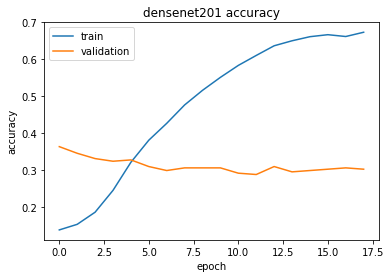

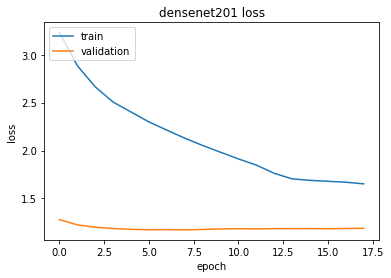

18/18 [==============================] - 3s 41ms/step
[[23 41 24]
 [47 38 22]
 [31 28 24]]
Acuracia balanceada na validacao: 0.30188681659518274


In [ ]:
cria_e_treina_rede('densenet201', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/500
508/508 [==============================] - 46s 77ms/step - loss: 2.7281 - acc: 0.3300 - val_loss: 1.1165 - val_acc: 0.3921
Epoch 2/500
508/508 [==============================] - 37s 73ms/step - loss: 2.6348 - acc: 0.3568 - val_loss: 1.1235 - val_acc: 0.3849
Epoch 3/500
508/508 [=====================

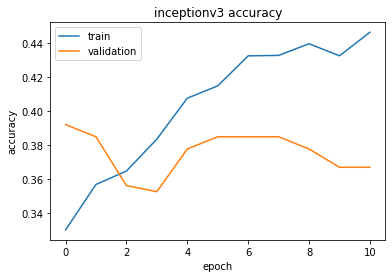

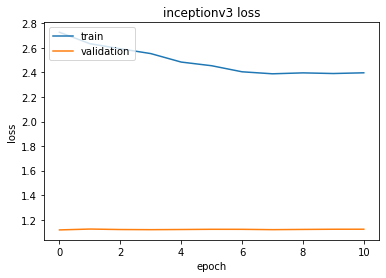

18/18 [==============================] - 2s 34ms/step
[[32 22 34]
 [31 39 37]
 [29 16 38]]
Acuracia balanceada na validacao: 0.3953178900819932


In [ ]:
cria_e_treina_rede('inceptionv3', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
219062272/219055592 [==============================] - 4s 0us/step
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 89s 283ms/step - loss: 2.6964 - acc: 0.2593 - val_loss: 1.1078 - val_acc: 0.3345
Epoch 2/500
254/254 [==============================] - 67s 265ms/step - loss: 2.6582 - acc: 0.2898 - val_loss: 1.1090 - val_acc: 0.3525
Epoch 3/500
254/254 [=================

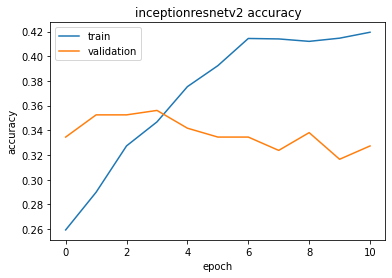

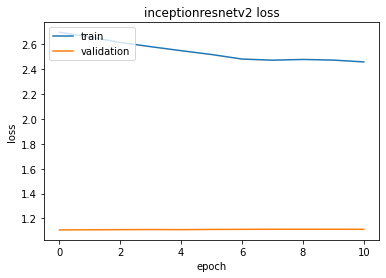

9/9 [==============================] - 3s 81ms/step
[[20 33 35]
 [22 43 42]
 [18 35 30]]
Acuracia balanceada na validacao: 0.330195889761254


In [ ]:
cria_e_treina_rede('inceptionresnetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 90s 336ms/step - loss: 2.7048 - acc: 0.1471 - val_loss: 1.1803 - val_acc: 0.3058
Epoch 2/500
254/254 [==============================] - 83s 328ms/step - loss: 2.6682 - acc: 0.1680 - val_loss: 1.1151 - val_acc: 0.3094
Epoch 3/500
254/254 [===================

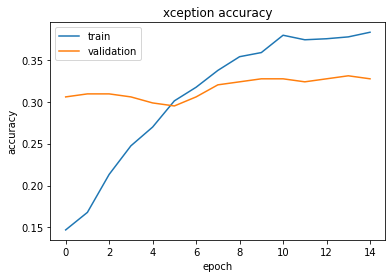

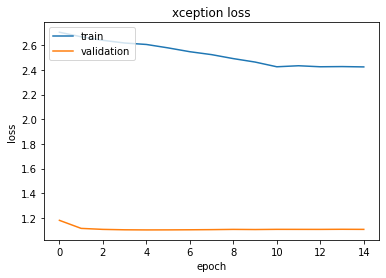

9/9 [==============================] - 1s 67ms/step
[[21 12 55]
 [30 18 59]
 [22 17 44]]
Acuracia balanceada na validacao: 0.3123270482098317


In [ ]:
cria_e_treina_rede('xception', train, val, callbacks=['earlystopping', 'reducelr'])

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 14,716,227
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
508/508 [==============================] - 48s 89ms/step - loss: 3.4466 - acc: 0.3289 - val_loss: 1.1673 - val_acc: 0.3813
Epoch 2/500
508/508 [==============================] - 43s 84ms/step - loss: 2.7730 - acc: 0.3170 - val_loss: 1.1140 - val_acc: 0.3741
Epoch 3/500
508/508 [==========================

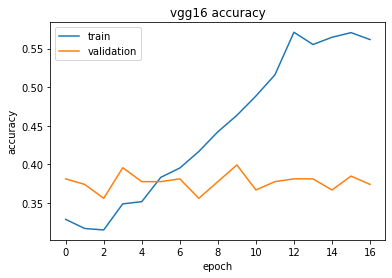

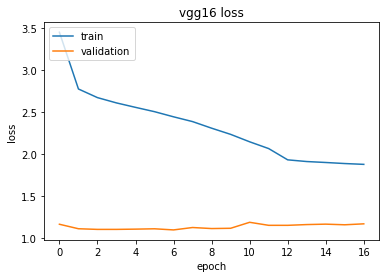

18/18 [==============================] - 1s 37ms/step
[[31 27 30]
 [38 35 34]
 [24 19 40]]
Acuracia balanceada na validacao: 0.38710108061813947


In [ ]:
cria_e_treina_rede('vgg16', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 8125 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 1539      
Total params: 20,025,923
Trainable params: 20,025,923
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
508/508 [==============================] - 52s 100ms/step - loss: 3.1496 - acc: 0.3687 - val_loss: 1.1569 - val_acc: 0.3453
Epoch 2/500
508/508 [==============================] - 51s 99ms/step - loss: 2.6874 - acc: 0.3809 - val_loss: 1.1230 - val_acc: 0.3921
Epoch 3/500
508/508 [=========================

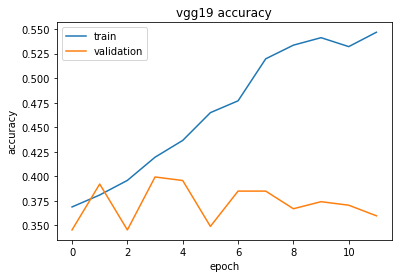

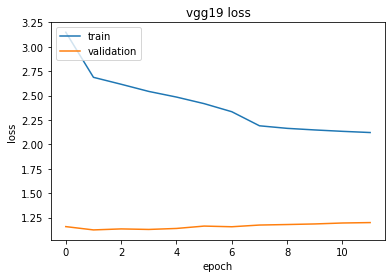

18/18 [==============================] - 1s 39ms/step
[[30 40 18]
 [29 52 26]
 [25 31 27]]
Acuracia balanceada na validacao: 0.38406386804652765


In [ ]:
cria_e_treina_rede('vgg19', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)